# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

% matplotlib inline

print(tf.__version__)


2.9.1


# Carregamento de dados

In [2]:
TRAINING_DATASET_SOURCE = 'training_data.csv'
TEST_DATASET_SOURCE = 'test_data.csv'

train_df = pd.read_csv(TRAINING_DATASET_SOURCE)
test_df = pd.read_csv(TEST_DATASET_SOURCE)

# SEED utilizada

In [43]:
SEED = 2022

# Preparação dos dados

In [44]:
categorical_to_numerical = {
    'avg_rain': {
        'Sem Chuva': 0,
        'chuva fraca': 1,
        'chuva moderada': 2,
        'chuva forte': 3
    },
    'luminosity': {
        'LOW_LIGHT': 0,
        'LIGHT': 1,
        'DARK': 2,
    }
}

incidents_to_numerical = {
    'incidents': {
        'None': 0,
        'Low': 1,
        'Medium': 2,
        'High': 3,
        'Very_High': 4,
    }
}

In [60]:
def neural_network_data_preparation(df: pd.DataFrame) -> pd.DataFrame:
    dropped_columns = ['city_name', 'magnitude_of_delay', 'avg_precipitation']

    prep_df = df.drop(dropped_columns, axis=1)

    ### Extrair a hora e dia da semana da feature 'record_date'
    record_date = pd.DatetimeIndex(prep_df['record_date'])

    prep_df['record_date_hour'] = record_date.hour
    prep_df['record_date_day'] = record_date.day
    prep_df['record_date_month'] = record_date.month
    prep_df['record_date_weekday'] = record_date.weekday

    prep_df.drop(columns=['record_date'], inplace=True)

    ### Quantificar a feature 'affected_roads' para o número único de estradas afetadas
    road_quantity = []
    for line in prep_df['affected_roads']:
        res = set(str(line).split(','))
        res2 = [elem for elem in res if elem != '']
        count = len(res2)
        road_quantity.append(count)

    prep_df['affected_roads'] = road_quantity

    prep_df.replace(categorical_to_numerical, inplace=True)

    ### Target
    if 'incidents' in prep_df.columns:
        prep_df.replace(incidents_to_numerical, inplace=True)

    return prep_df

In [61]:
X = neural_network_data_preparation(train_df)

In [47]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   delay_in_seconds     5000 non-null   int64  
 1   affected_roads       5000 non-null   int64  
 2   luminosity           5000 non-null   int64  
 3   avg_temperature      5000 non-null   float64
 4   avg_atm_pressure     5000 non-null   float64
 5   avg_humidity         5000 non-null   float64
 6   avg_wind_speed       5000 non-null   float64
 7   avg_rain             5000 non-null   int64  
 8   incidents            5000 non-null   int64  
 9   record_date_hour     5000 non-null   int64  
 10  record_date_day      5000 non-null   int64  
 11  record_date_month    5000 non-null   int64  
 12  record_date_weekday  5000 non-null   int64  
dtypes: float64(4), int64(9)
memory usage: 507.9 KB


In [48]:
y = X['incidents']

X.drop(columns=['incidents'], inplace=True)

In [49]:
scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_scaled = pd.DataFrame(scaler_X.transform(X[X.columns]), columns=X.columns)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=SEED)

# Construção da estrutura da rede neuronal

In [69]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [73]:
from tensorflow import keras

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

def build_model():
    model = keras.Sequential()

    model.add(Dense(16, input_dim=12, activation='relu'))  # Input Layer

    model.add(Dense(8, activation="relu"))

    model.add(Dense(5, activation='softmax'))  # Output Layer

    # Model compilation
    model.compile(loss=SparseCategoricalCrossentropy(), optimizer=get_optimizer(),#keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    return model


In [74]:
model = build_model()

In [75]:
history = model.fit(X_train, y_train, epochs=20, batch_size=8)

Epoch 1/20
500/500 [==============================] - 1s 658us/step - loss: 1.4965 - accuracy: 0.3650
Epoch 2/20
500/500 [==============================] - 0s 659us/step - loss: 1.3482 - accuracy: 0.4520
Epoch 3/20
500/500 [==============================] - 0s 669us/step - loss: 1.1683 - accuracy: 0.5515
Epoch 4/20
500/500 [==============================] - 0s 658us/step - loss: 1.0552 - accuracy: 0.6070
Epoch 5/20
500/500 [==============================] - 0s 670us/step - loss: 0.9992 - accuracy: 0.6283
Epoch 6/20
500/500 [==============================] - 0s 639us/step - loss: 0.9708 - accuracy: 0.6302
Epoch 7/20
500/500 [==============================] - 0s 658us/step - loss: 0.9468 - accuracy: 0.6425
Epoch 8/20
500/500 [==============================] - 0s 639us/step - loss: 0.9294 - accuracy: 0.6460
Epoch 9/20
500/500 [==============================] - 0s 638us/step - loss: 0.9135 - accuracy: 0.6520
Epoch 10/20
500/500 [==============================] - 0s 626us/step - loss: 0.901

-------
-------
-------

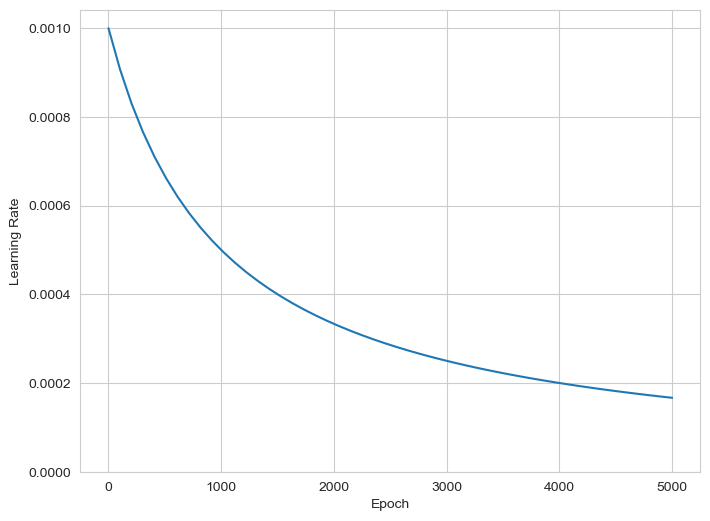

In [76]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [55]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

32/32 [==============================] - 0s 1ms/step - loss: 0.6432 - accuracy: 0.7650


In [56]:
predicts = model.predict(X_test)

categories_predicted = [np.argmax(pred) for pred in predicts]

32/32 [==============================] - 0s 504us/step


In [57]:
predicts

array([[4.75691229e-01, 2.22463757e-01, 1.68854594e-01, 1.30061507e-01,
        2.92889099e-03],
       [6.20517631e-06, 2.05465872e-02, 4.00241464e-02, 2.86401331e-01,
        6.53021812e-01],
       [7.65914798e-01, 1.87089309e-01, 4.68937233e-02, 1.02171594e-04,
        2.82225869e-08],
       ...,
       [3.06977949e-04, 4.08356115e-02, 1.07213750e-01, 5.76981843e-01,
        2.74661809e-01],
       [8.21162641e-01, 1.55125350e-01, 2.36095060e-02, 1.02119833e-04,
        2.52276863e-07],
       [4.32011366e-01, 6.49048686e-02, 1.61545783e-01, 3.37455899e-01,
        4.08200454e-03]], dtype=float32)

In [58]:
categories_predicted

[0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 3,
 0,
 0,
 3,
 4,
 0,
 3,
 1,
 0,
 3,
 4,
 0,
 3,
 0,
 4,
 1,
 0,
 0,
 0,
 3,
 3,
 4,
 4,
 4,
 3,
 0,
 1,
 0,
 2,
 3,
 0,
 1,
 0,
 0,
 0,
 2,
 2,
 0,
 4,
 4,
 0,
 3,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 3,
 0,
 2,
 0,
 0,
 0,
 0,
 3,
 0,
 3,
 3,
 3,
 4,
 1,
 3,
 4,
 0,
 0,
 0,
 1,
 0,
 3,
 3,
 3,
 3,
 2,
 0,
 0,
 4,
 0,
 0,
 3,
 3,
 2,
 4,
 0,
 0,
 0,
 0,
 1,
 3,
 0,
 3,
 4,
 3,
 1,
 2,
 3,
 0,
 0,
 3,
 3,
 2,
 0,
 4,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 1,
 3,
 3,
 4,
 0,
 3,
 1,
 2,
 3,
 4,
 3,
 0,
 3,
 0,
 3,
 2,
 0,
 3,
 3,
 0,
 1,
 0,
 1,
 4,
 0,
 0,
 1,
 0,
 3,
 3,
 0,
 0,
 4,
 4,
 3,
 4,
 4,
 0,
 0,
 3,
 4,
 0,
 3,
 2,
 2,
 0,
 0,
 0,
 1,
 2,
 3,
 3,
 3,
 0,
 3,
 2,
 0,
 1,
 0,
 4,
 0,
 4,
 4,
 1,
 0,
 3,
 0,
 3,
 1,
 3,
 3,
 0,
 4,
 0,
 0,
 3,
 3,
 0,
 3,
 3,
 0,
 3,
 2,
 0,
 3,
 3,
 0,
 0,
 0,
 3,
 3,
 0,
 0,
 3,
 0,
 0,
 4,
 1,
 0,
 3,
 2,
 3,
 0,
 0,
 3,
 0,
 4,
 2,
 3,
 2,
 4,
 0,
 3,
 0,
 4,
 0,
 0,


In [59]:
y_test

3419    1
178     4
3721    0
3087    0
3685    1
       ..
3884    4
3855    0
2070    4
1482    0
2602    0
Name: incidents, Length: 1000, dtype: int64

# Obter as previsões no dataset de submissão

In [18]:
X = neural_network_data_preparation(test_df)

scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_scaled = pd.DataFrame(scaler_X.transform(X[X.columns]), columns=X.columns)

X_scaled

,affected_roads,avg_atm_pressure,avg_humidity,avg_wind_speed,rain,delay,luminosity_binned,record_date_hour,record_date_month,record_date_weekday,temperature
0,0.142857,0.59375,0.784946,0.000000,0.0,1.0,0.5,0.826087,0.272727,0.166667,0.5
1,0.142857,0.59375,0.365591,0.222222,0.0,0.0,1.0,0.173913,0.818182,0.333333,0.5
2,0.142857,0.56250,0.688172,0.000000,0.0,0.0,0.5,0.826087,0.545455,1.000000,1.0
3,0.285714,0.28125,0.795699,0.333333,0.0,1.0,0.5,0.652174,0.818182,0.833333,0.5
4,0.142857,0.71875,0.849462,0.000000,0.0,0.0,0.5,0.434783,0.818182,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1201,0.142857,0.81250,0.677419,0.222222,0.0,0.0,0.5,0.434783,1.000000,0.666667,0.5
1202,0.142857,0.53125,0.344086,0.222222,0.0,1.0,1.0,0.000000,0.545455,0.666667,1.0
1203,0.142857,0.59375,0.569892,0.000000,0.0,1.0,0.5,0.652174,1.000000,1.000000,0.5
1204,0.142857,0.50000,0.462366,0.111111,0.0,1.0,0.5,0.739130,0.181818,0.000000,0.5


In [79]:
categories_prob_predictions = model.predict(X_scaled)

categories_prob_predictions

157/157 [==============================] - 0s 581us/step


array([[8.06052864e-01, 1.08760618e-01, 6.04739301e-02, 2.35867519e-02,
        1.12582510e-03],
       [9.02602673e-01, 7.87358657e-02, 1.40679125e-02, 4.52117668e-03,
        7.22777186e-05],
       [8.35287452e-01, 1.21180668e-01, 3.17842290e-02, 1.10725844e-02,
        6.74955838e-04],
       ...,
       [9.09227788e-01, 3.51204611e-02, 4.22889255e-02, 1.31193772e-02,
        2.43412243e-04],
       [8.09608102e-01, 1.49051800e-01, 1.99526288e-02, 2.07594763e-02,
        6.27925037e-04],
       [9.07103837e-01, 7.61709660e-02, 1.32241165e-02, 3.44768935e-03,
        5.34562278e-05]], dtype=float32)

In [80]:
numerical_predictions = [np.argmax(pred) for pred in categories_prob_predictions]

numerical_predictions[:10]

[0, 0, 0, 4, 0, 0, 0, 3, 3, 4]

In [81]:
numerical_predictions_df = pd.DataFrame(numerical_predictions)

incidents_categories = {
    0: 'None',
    1: 'Low',
    2: 'Medium',
    3: 'High',
    4: 'Very_High',
}

predictions_df = numerical_predictions_df.replace(incidents_categories)

In [82]:
predictions_df.index += 1

predictions_df.to_csv("submission.csv", header=['Incidents'], index_label='RowId')